In [25]:
import pandas as pd

# 1. 파일 불러오기
df = pd.read_csv("./dataset/must_use_final.csv")  # 파일 경로 조정 필요

# 2. 클러스터별 고유 항구 리스트 추출
cluster_port_list = df.groupby('CLUSTER_1')['PORT_NAME'].unique().reset_index()

# 3. 리스트를 문자열로 변환 + 항구 개수 추가
cluster_port_list['PORT_LIST'] = cluster_port_list['PORT_NAME'].apply(
    lambda x: "[" + ", ".join(sorted(x)) + "]"
)
cluster_port_list['PORT_COUNT'] = cluster_port_list['PORT_NAME'].apply(len)

# 4. 컬럼 정리
cluster_port_list = cluster_port_list[['CLUSTER_1', 'PORT_COUNT', 'PORT_LIST']]
cluster_port_list.columns = ['CLUSTER', 'PORT_COUNT', 'PORT_LIST']

# 5. 출력 옵션 설정 (PORT_LIST 생략 방지)
pd.set_option('display.max_colwidth', None)

# 6. 출력 (Jupyter Notebook에서는 자동 테이블, 콘솔에선 전체 표시)
display(cluster_port_list)
# 또는 콘솔 출력 시:
# print(cluster_port_list.to_string(index=False))


,CLUSTER,PORT_COUNT,PORT_LIST
0,0,1,[PHMNL]
1,1,11,"[JPHIJ, JPHKT, JPIMB, JPIMI, JPMOJ, JPNGS, KRINC, KRKAN, KRKPO, KRPTK, KRYOS]"
2,2,4,"[CNNGB, CNNJI, CNSHA, CNTAC]"
3,3,10,"[JPKIJ, JPMKX, JPNGO, JPOSA, JPSMZ, JPTYO, JPUKB, JPWAK, JPYKK, JPYOK]"
4,4,4,"[CNHUA, HKHKG, TWKEL, TWKHH]"
5,5,1,[VNHPH]
6,6,5,"[CNDAG, CNLYG, CNQDG, CNRZH, CNTXG]"
7,7,2,"[RUNJK, RUVVO]"


In [29]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/must_use_final.csv")
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# 2. 선박별 출발/도착 시점 추출
vessel_time = df.groupby('VSL_ID')['TIMESTAMP'].agg(['min', 'max']).reset_index()
vessel_time['DURATION_HR'] = (vessel_time['max'] - vessel_time['min']).dt.total_seconds() / 3600

# 3. 선박별 마지막 항구(CLUSTER 포함) 정보 추출
last_rows = df.sort_values('TIMESTAMP').groupby('VSL_ID').tail(1)[['VSL_ID', 'PORT_NAME', 'CLUSTER_1', 'LAT', 'LON']]

# 4. 선박 통계와 군집 정보 결합
vessel_summary = pd.merge(vessel_time, last_rows, on='VSL_ID')

# 5. 군집별 통계 계산
cluster_stats = vessel_summary.groupby('CLUSTER_1').agg({
    'DURATION_HR': 'mean',
    'PORT_NAME': pd.Series.nunique,
    'VSL_ID': 'nunique',
    'LAT': 'mean',
    'LON': 'mean'
}).reset_index()

# 6. 컬럼명 정리
cluster_stats.columns = ['CLUSTER', 'AVG_DURATION_HR', 'PORT_COUNT', 'UNIQUE_VSL', 'LAT', 'LON']

# 7. 전체 데이터 개수 추가
data_counts = df.groupby('CLUSTER_1').size().reset_index(name='DATA_COUNT')
cluster_stats = pd.merge(cluster_stats, data_counts, left_on='CLUSTER', right_on='CLUSTER_1').drop(columns='CLUSTER_1')

# 8. 결과 확인
display(cluster_stats)


,CLUSTER,AVG_DURATION_HR,PORT_COUNT,UNIQUE_VSL,LAT,LON,DATA_COUNT
0,0,1232.888889,1,3,14.585364,120.964368,3874
1,1,604.106061,11,154,35.237077,127.998632,28307
2,2,369.661765,4,68,31.274213,121.607522,43638
3,3,1115.135965,8,38,35.538642,137.616657,25461
4,4,448.740000,4,25,23.397606,117.703129,14686
5,5,895.000000,1,4,20.834582,106.784143,6338
6,6,932.397436,4,39,36.405003,119.799835,19186
7,7,549.444444,2,15,43.033145,132.082360,10266


# 군집별 통계 요약 코드

In [121]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/must_use_final.csv")  # 경로는 상황에 맞게 수정
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# 2. 선박별 출발~도착 소요 시간 계산
vessel_time = df.groupby('VSL_ID')['TIMESTAMP'].agg(['min', 'max']).reset_index()
vessel_time['DURATION_HR'] = (vessel_time['max'] - vessel_time['min']).dt.total_seconds() / 3600

# 3. 선박별 CLUSTER_1 추출 (CLUSTER_1은 유일하다고 가정됨)
cluster_info = df[['VSL_ID', 'CLUSTER_1']].drop_duplicates()
vessel_summary = pd.merge(vessel_time, cluster_info, on='VSL_ID')

# 4. 군집별 평균 소요 시간 계산
cluster_duration = vessel_summary.groupby('CLUSTER_1')['DURATION_HR'].mean().reset_index()
cluster_duration.columns = ['CLUSTER', '평균 소요시간(HR)']

# 5. 군집별 선박 수 계산
ship_counts = cluster_info.groupby('CLUSTER_1').size().reset_index(name='선박의 수')
ship_counts.columns = ['CLUSTER', '선박의 수']

# 6. 군집별 전체 행 수 계산
row_counts = df.groupby('CLUSTER_1').size().reset_index(name='데이터 포인트 수(행 개수)')
row_counts.columns = ['CLUSTER', '데이터 포인트 수(행 개수)']

# 7. 소요 시간 포맷 함수 정의
def format_duration(hours):
    total_minutes = int(hours * 60)
    days = total_minutes // (24 * 60)
    hours = (total_minutes % (24 * 60)) // 60
    minutes = total_minutes % 60
    return f"{days}일 {hours}시간 {minutes}분"

# 8. 포맷 적용
cluster_duration['평균 소요시간'] = cluster_duration['평균 소요시간(HR)'].apply(format_duration)
cluster_duration = cluster_duration.drop(columns='평균 소요시간(HR)')

# 9. 결과 병합
summary = pd.merge(ship_counts, cluster_duration, on='CLUSTER')
summary = pd.merge(summary, row_counts, on='CLUSTER')

# 10. 출력
display(summary)
# summary.to_csv("cluster_summary.csv", index=False)  ← 저장하고 싶을 경우!


,CLUSTER,선박의 수,평균 소요시간,데이터 포인트 수(행 개수)
0,0,4,73일 13시간 5분,3874
1,1,199,36일 13시간 50분,28307
2,2,88,32일 21시간 50분,43638
3,3,55,57일 17시간 51분,25461
4,4,31,28일 1시간 19분,14686
5,5,9,57일 13시간 14분,6338
6,6,49,42일 16시간 20분,19186
7,7,25,42일 18시간 5분,10266


In [10]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/must_use_final.csv")  # 경로는 상황에 맞게 수정
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# 2. 선박별 출발~도착 소요 시간 계산
vessel_time = df.groupby('VSL_ID')['TIMESTAMP'].agg(['min', 'max']).reset_index()
vessel_time['DURATION_HR'] = (vessel_time['max'] - vessel_time['min']).dt.total_seconds() / 3600

# 3. 선박별 CLUSTER_1 추출 (CLUSTER_1은 유일하다고 가정됨)
cluster_info = df[['VSL_ID', 'CLUSTER_1']].drop_duplicates()
vessel_summary = pd.merge(vessel_time, cluster_info, on='VSL_ID')

# 4. 군집별 통계 계산: 선박 수 + 소요 시간 평균/최소/최대
cluster_duration = vessel_summary.groupby('CLUSTER_1').agg(
    선박의_수=('VSL_ID', 'nunique'),
    최소_소요시간_HR=('DURATION_HR', 'min')
).reset_index()
cluster_duration = cluster_duration.rename(columns={'CLUSTER_1': 'CLUSTER'})

# 5. 군집별 전체 행 수 계산
row_counts = df.groupby('CLUSTER_1').size().reset_index(name='데이터 포인트 수(행 개수)')
row_counts.columns = ['CLUSTER', '행 개수']

# 6. 소요 시간 포맷 함수 정의
def format_duration(hours):
    total_minutes = int(hours * 60)
    days = total_minutes // (24 * 60)
    hours = (total_minutes % (24 * 60)) // 60
    minutes = total_minutes % 60
    return f"{days}일 {hours}시간 {minutes}분"

# 7. 포맷된 시간 컬럼 추가

cluster_duration['최소 소요시간'] = cluster_duration['최소_소요시간_HR'].apply(format_duration)

# 8. 불필요한 원시 시간 컬럼 제거
cluster_duration = cluster_duration.drop(columns=[
     '최소_소요시간_HR'
])

# 9. 병합
summary = pd.merge(cluster_duration, row_counts, on='CLUSTER')

# 10. 출력
display(summary)
# summary.to_csv("cluster_summary_extended.csv", index=False)

,CLUSTER,선박의_수,최소 소요시간,행 개수
0,0,4,5일 5시간 10분,3874
1,1,199,0일 6시간 30분,28307
2,2,88,1일 10시간 20분,43638
3,3,55,1일 0시간 50분,25461
4,4,31,1일 18시간 0분,14686
5,5,9,4일 16시간 20분,6338
6,6,49,1일 8시간 39분,19186
7,7,25,1일 14시간 20분,10266


In [26]:
vessel_count = df[['CLUSTER_1', 'VSL_ID','PORT_NAME']].drop_duplicates() \
                .groupby('CLUSTER_1').size().reset_index(name='선박 수')

display(vessel_count)

,CLUSTER_1,선박 수
0,0,4
1,1,245
2,2,91
3,3,93
4,4,32
5,5,9
6,6,57
7,7,25


In [21]:
# 정확하게 VSL_ID + PORT_NAME 조합별 선박 수 (군집 기준 포함)
accurate_ship_count = df[['VSL_ID', 'PORT_NAME', 'CLUSTER_1']].drop_duplicates()
accurate_count = accurate_ship_count['CLUSTER_1'].value_counts()
print(accurate_count)

CLUSTER_1
1    245
3     93
2     91
6     57
4     32
7     25
5      9
0      4
Name: count, dtype: int64


In [30]:
import pandas as pd

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("./dataset/cluster1_2.csv")
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# 2. 선박별 5시간 시점 필터링 (30개 이상 데이터 가진 선박)
rows_5h = []
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 30:
        row_5h = group.iloc[29]
        rows_5h.append(row_5h)
df_5h = pd.DataFrame(rows_5h).reset_index(drop=True)

# 3. 선박 수 계산 (VSL_ID + PORT_NAME 기준, 군집 포함)
ship_counts = df[['VSL_ID', 'PORT_NAME', 'CLUSTER_2']].drop_duplicates()
vessel_count = ship_counts.groupby('CLUSTER_2').size().reset_index(name='선박 수')
vessel_count.columns = ['CLUSTER', '선박 수']

# 4. 선박별 행 개수 → 군집별 총합
row_counts = df.groupby(['VSL_ID', 'PORT_NAME', 'CLUSTER_2']).size().reset_index(name='행 개수')
cluster_row_sum = row_counts.groupby('CLUSTER_2')['행 개수'].sum().reset_index()
cluster_row_sum.columns = ['CLUSTER', '총 행 개수']

# 5. 소요시간 계산: VSL_ID + PORT_NAME + CLUSTER_2 기준
duration_df = df.groupby(['CLUSTER_2', 'VSL_ID', 'PORT_NAME'])['TIMESTAMP'].agg(['min', 'max']).reset_index()
duration_df['DURATION_HR'] = (duration_df['max'] - duration_df['min']).dt.total_seconds() / 3600

# 6. 군집별 평균 소요시간 계산
cluster_avg_duration = duration_df.groupby('CLUSTER_2')['DURATION_HR'].mean().reset_index()
cluster_avg_duration.columns = ['CLUSTER', '평균 소요시간(HR)']

# 7. 시간 포맷 함수
def format_duration(hours):
    total_minutes = int(hours * 60)
    days = total_minutes // (24 * 60)
    hours = (total_minutes % (24 * 60)) // 60
    minutes = total_minutes % 60
    return f"{days}일 {hours}시간 {minutes}분"

cluster_avg_duration['평균 소요시간'] = cluster_avg_duration['평균 소요시간(HR)'].apply(format_duration)
cluster_avg_duration = cluster_avg_duration.drop(columns='평균 소요시간(HR)')

# 8. 병합
summary = pd.merge(vessel_count, cluster_avg_duration, on='CLUSTER')
summary = pd.merge(summary, cluster_row_sum, on='CLUSTER')

# 9. 출력
display(summary)

,CLUSTER,선박 수,평균 소요시간,총 행 개수
0,0,11,3일 14시간 2분,5690
1,1,4,2일 8시간 22분,1357
2,2,72,3일 9시간 20분,35209
3,3,4,2일 9시간 25분,1382


# 1단계: PHMNL로 향하는 선박 목록 보기

In [106]:
phmnl_vessels = df[df['CLUSTER_1'] == 1]['VSL_ID'].unique()
print("CLUSTER 별 선박 목록:", phmnl_vessels)
print("총 개수:", len(phmnl_vessels))

CLUSTER 별 선박 목록: ['5eeb009d-9000-33a4-846d-e9f8d35a3f0e'
 'c9863dc8-5b84-36ab-8ae3-7660309bf305'
 'efbd8128-ef1f-3060-b8dc-f4d38f9d6094'
 'aa75c735-e1c0-32c7-a301-7a2bdae8b877'
 'ac815948-35fa-3062-bfda-d8a57d19e302'
 '7fbee447-c1f0-3e32-80df-2aeda46a9704'
 '95ccc506-5141-391e-9028-8943ad7e0f96'
 '95cd1331-5eb4-3c70-be83-2b37850db7ac'
 'beb5c997-3574-3ead-88de-cc0035c4d0db'
 '771e4fc5-8f81-3f95-bc47-6fdc9d2c7dec'
 'f7cf03dc-f403-31bd-bcb6-0d85f2bc7271'
 '61901f79-4200-3f80-860f-88feffa27855'
 '97aaadda-b511-3eb1-8d5e-1cce4931a161'
 'ba6f4194-f5d1-37a2-b91d-d12986f6acfa'
 'baf57340-451d-3a65-81a2-fde185adfbc6'
 'ff17fbdd-ab98-3ce8-8d81-4ef76ba284d6'
 '76f57dc9-cca4-3883-a4e7-54ad829b696b'
 '8f132db2-f0dc-3145-a294-eb52c8bec834'
 '9a6fc43a-8fd5-3e5c-89e1-20dbeb3f8229'
 '4ec4cb37-8afd-3e90-9af5-090509f5bca6'
 '06aef475-e619-31a5-8baa-85d2c1928176'
 '388a7a93-8dff-3e0e-bb4f-568293bf7f4b'
 '282edc9e-d2de-3818-874a-2f58c970cd19'
 '62556dcc-51d4-328d-8bb3-f5786b716179'
 '0dc7f810-8861-32a6-ba

In [108]:
# ✅ 정확한 통계용 (최종 도착 기준)
vessel_summary['CLUSTER_1'].value_counts()

# ❗ 전체 기록 중 포함된 선박 수 (중간 경유 포함)
df[df['CLUSTER_1'] == 1]['VSL_ID'].nunique()

199

# 2단계: 그 선박들의 CLUSTER_1 확인

In [96]:
# 각 VSL_ID의 마지막 CLUSTER_1 확인
phmnl_cluster_check = df[df['VSL_ID'].isin(phmnl_vessels)].sort_values('TIMESTAMP') \
    .groupby('VSL_ID').tail(1)[['VSL_ID', 'PORT_NAME', 'CLUSTER_1']]

print(phmnl_cluster_check)

                                      VSL_ID PORT_NAME  CLUSTER_1
27330   5f688de9-0b74-3793-bf16-0baea35597bf     PHMNL          0
124213  9faa6003-17ab-3412-896e-04eb09f6c434     CNTXG          6
28346   5808b892-f82c-3357-90e3-85effb0df39a     PHMNL          0
30452   ba7f84fe-0af9-3851-86b5-6a302f5e6cb0     PHMNL          0


# 군집 별 5시간 시점의 개수 찾기

In [ ]:
import warnings
warnings.filterwarnings("ignore")   # 경고 메세지 무시

import pandas as pd
import numpy as np

# ===== 1. 파일 불러오기 및 정렬 =====
df = pd.read_csv("./datasets/must_use_final.csv")  
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"]) # TIMESTAMP 컬럼을 datetime 형식으로 변환
df = df.sort_values("TIMESTAMP").reset_index(drop=True) # 시간 기준 정렬 및 인덱스 리셋 

# ===== 2. 출발 후 5시간 시점 추출 =====
max_gap = pd.Timedelta(minutes=10)  # 목표 시간과 실제 데이터 시간 차이 허용 범위(±10분)
target_hour = 5   # 출발 후 5시간으로 목표 시점 설정
time_based_rows = []   # 조건 만족하는 행 저장할 리스트

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP") # 시간 순 정렬
    if group.empty:
        continue
    start_time = group["TIMESTAMP"].min() # 최솟값(가장 작은 값)을 구함, 숫자 뿐 아니라 datetime(날짜)에도 사용 가능 > 출항 시점 찾기
    target_time = start_time + pd.Timedelta(hours=target_hour) # 출발~5시간째 되는 시간 찾기
    time_diff = (group["TIMESTAMP"] - target_time).abs() # 각 시간과 목표 시간의 차이 계산 
    closest_idx = time_diff.idxmin() # 가장 가까운 시간의 인덱스를 찾음
    if time_diff[closest_idx] <= max_gap: # 10분 이내 차이면 유효한 값으로 인정 
        time_based_rows.append(group.loc[closest_idx]) # 조건 맞는 행을 인덱스에 추가 

df_5h = pd.DataFrame(time_based_rows).reset_index(drop=True)

In [45]:
import pandas as pd
import os

# 울산항 파일들이 들어있는 폴더
folder_path = './dataset/KRUSN'

# 누적 저장 리스트
durations = []

# 시간 포맷 함수
def format_duration(hours):
    total_minutes = int(hours * 60)
    days = total_minutes // (24 * 60)
    hours = (total_minutes % (24 * 60)) // 60
    minutes = total_minutes % 60
    return f"{days}일 {hours}시간 {minutes}분"

# 폴더 내 각 선박 파일 반복 처리
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
        duration_hr = (df['TIMESTAMP'].max() - df['TIMESTAMP'].min()).total_seconds() / 3600
        durations.append(duration_hr)

# 통계 계산
min_duration = min(durations)
max_duration = max(durations)
avg_duration = sum(durations) / len(durations)
count = len(durations)

# 포맷 적용
result = pd.DataFrame([{
    'PORT_NAME': 'KRUSN',
    'COUNT': count,
    '최소 소요 시간': format_duration(min_duration),
    '최대 소요 시간': format_duration(max_duration),
    '평균 소요 시간': format_duration(avg_duration)
}])

# 결과 출력
display(result)


,PORT_NAME,COUNT,최소 소요 시간,최대 소요 시간,평균 소요 시간
0,KRUSN,133,0일 2시간 0분,11일 15시간 40분,0일 10시간 23분


In [58]:
import pandas as pd
import os

# 1. 폴더 경로 설정
folder_path = './dataset/KRUSN'  # 목적항 CSV 파일이 들어있는 폴더

# 2. 누적 저장 리스트
all_stats = []

# 3. 소요 시간 포맷 함수 정의
def format_duration(hours):
    total_minutes = int(hours * 60)
    days = total_minutes // (24 * 60)
    hours = (total_minutes % (24 * 60)) // 60
    minutes = total_minutes % 60
    return f"{days}일 {hours}시간 {minutes}분"

# 4. 폴더 내 모든 CSV 파일 반복 처리
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        # TIMESTAMP를 datetime 형식으로 변환
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

        # VSL_ID별 출발/도착 시간 계산
        vessel_time = df.groupby('VSL_ID')['TIMESTAMP'].agg(['min', 'max']).reset_index()
        vessel_time['DURATION_HR'] = (vessel_time['max'] - vessel_time['min']).dt.total_seconds() / 3600

        # PORT_NAME은 파일명(확장자 제거)으로 간주
        port_name = os.path.splitext(filename)[0]
        vessel_time['PORT_NAME'] = port_name

        # 누적 리스트에 추가
        all_stats.append(vessel_time)

# 5. 모든 파일 결과 합치기
all_vessel_stats = pd.concat(all_stats, ignore_index=True)

# 6. 항구별 소요 시간 통계 계산
port_duration_stats = all_vessel_stats.groupby('PORT_NAME')['DURATION_HR'].agg(
    MIN_DURATION_HR='min',
    MAX_DURATION_HR='max',
    AVG_DURATION_HR='mean',
    COUNT='count'
).reset_index()

# 7. 포맷된 시간 컬럼 추가
port_duration_stats['MIN_DURATION_FORMATTED'] = port_duration_stats['MIN_DURATION_HR'].apply(format_duration)
port_duration_stats['MAX_DURATION_FORMATTED'] = port_duration_stats['MAX_DURATION_HR'].apply(format_duration)
port_duration_stats['AVG_DURATION_FORMATTED'] = port_duration_stats['AVG_DURATION_HR'].apply(format_duration)

# 8. 원시 수치 컬럼 제거
final_stats = port_duration_stats.drop(columns=[
    'MIN_DURATION_HR', 'MAX_DURATION_HR', 'AVG_DURATION_HR'
])

# 9. 결과 출력 또는 저장
print(final_stats)
# final_stats.to_csv('항구별_소요시간_요약.csv', index=False)  # 저장도 가능


                                PORT_NAME  COUNT MIN_DURATION_FORMATTED  \
0    00d079c8-1ab3-3973-828a-9eac373785c5      1             0일 2시간 40분   
1    019afa9b-ec15-34d6-94a5-7fdb385e6999      1             0일 2시간 30분   
2    0803fc48-0e15-3d76-b8c3-e8d7f11a6acc      1              0일 3시간 0분   
3    0839d02b-3afd-30d1-a5c7-6231545afdb6      1             0일 2시간 50분   
4    0d67e314-3d75-3de9-9440-47e265f3421f      1             0일 20시간 0분   
..                                    ...    ...                    ...   
128  f35c6b1f-f4e4-3a0a-91ec-cb35d076301a      1             0일 2시간 10분   
129  f6364f61-bd9b-3103-9f8d-7d6a4861606c      1             0일 15시간 0분   
130  f70d239a-5451-3d38-b67b-0a9b5572ca76      1              0일 4시간 0분   
131  f8644557-06ce-3897-9893-721535a6b595      1             0일 3시간 50분   
132  f935be69-6061-38e8-a889-1b22370edd2a      1             0일 2시간 30분   

    MAX_DURATION_FORMATTED AVG_DURATION_FORMATTED  
0               0일 2시간 40분             0일 2시간 4

# 실루엣 계수

29
(38, 3)
(38, 3)


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

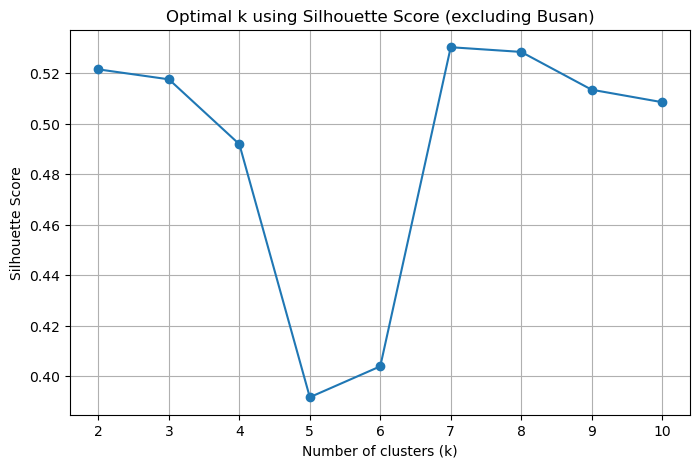

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [62]:
ports = pd.read_csv('./dataset/port.csv')
ports['PORT_CD'].unique()
remove_ports = ['CNSHK','CNTAS','CNYTG','CNYTN',
                    'JPFKY', 'JPHIC', 'JPKNZ', 'JPKOM', 'JPMIZ', 'JPNAO', 'JPONA', 'JPSBS', 'JPSDJ', 'JPSHS', 'JPSKT', 'JPSMN', 'JPTOS',
                    'JPTXD','KRBNP','KRKCN','KRKUV','KRMAS','KRPUS', 'RUVYP','KRUSN',
                    'SGSIN','TWTPE','VNCLI','VNSGN']
print(len(remove_ports))
filtered_ports = ports[~ports['PORT_CD'].isin(remove_ports)]
#filtered_ports.to_csv('../dataset/FINAL/ports_final.csv', index=False)
print(filtered_ports.shape)

# 실루엣 계수를 사용하여 최적의 k 찾기 -> 유클리드 거리 기반
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

ports = pd.read_csv('./dataset/ports_final.csv')
print(ports.shape)
map_center = [35.1, 129.04]  # 부산항

X = ports[['LOC_LAT', 'LOC_LON']] # 부산항이 포함되어 있지 않음.

silhouette_scores = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal k using Silhouette Score (excluding Busan)')
plt.grid(True)
plt.show()
# k=9 or 8 -> 군집 수가 너무 많으면 복잡해질 수도 있으므로 예측 정확도나 군집별 의미 분석 등을 통해 선택

pd.set_option('display.max_colwidth', None)
# 실루엣 계수가 높은 군집 수 결정하여 KMeans
# k = 8
from sklearn.cluster import KMeans

ports = pd.read_csv('./dataset/ports_final.csv')

# KMeans 클러스터링 (k=8)
X = ports[['LOC_LAT', 'LOC_LON']]

kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(X)

# 클러스터 결과 저장
ports['CLUSTER'] = labels

# 군집별 항구 목록을 리스트로 정리
cluster_ports = ports.groupby('CLUSTER')['PORT_CD'].apply(list).reset_index()

# 항구 개수 컬럼 추가
cluster_ports['PORT_COUNT'] = cluster_ports['PORT_CD'].apply(len)

# 컬럼 순서 정리
cluster_ports = cluster_ports.rename(columns={'PORT_CD': 'PORT_LIST'})
cluster_ports = cluster_ports[['CLUSTER', 'PORT_COUNT', 'PORT_LIST']]
cluster_ports

import folium

# 지도 생성
map_center = [35.1, 129.04]
m = folium.Map(location=map_center, zoom_start=4)

# 색상 리스트 (군집 수만큼 필요)
colors = [
    'red', 'blue', 'green', 'purple', 'orange',
    'brown', 'white', 'yellow', 'pink', 'gray'
]

# 마커 표시 (클러스터 없이, 모든 항구 개별 표시)
for idx, row in ports.iterrows():
    cluster = row['CLUSTER']
    popup_text = f"PORT: {row['PORT_CD']}<br>CLUSTER: {cluster}"

    folium.CircleMarker(
    location=[row['LOC_LAT'], row['LOC_LON']],
    radius=6,
    color=colors[cluster % len(colors)],       # 테두리 색
    fill=True,
    fill_opacity=0.7,
    popup=popup_text
).add_to(m)

# 저장
m.save('./dataset/cluster_eight_map.html')
m

In [12]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/cluster1_7.csv")

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# 결과 저장 리스트
rows_5h = []

# 30번째 시점 추출 (10분 단위 × 30 = 5시간)
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 30:
        row_5h = group.iloc[29]  # 인덱스는 0부터 시작이므로 29번째가 30번째 행
        rows_5h.append(row_5h)

# 최종 데이터프레임
df_5h = pd.DataFrame(rows_5h).reset_index(drop=True)
print(df_5h.shape)
display(df_5h.head())
display(df_5h['PORT_NAME'].value_counts())

df_5h[['LAT', 'LON', 'COG', 'HEADING','PORT_NAME']].to_csv('./dataset/CLUSTER_7.csv', index=False)

(25, 11)


,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2
0,RU,RUVVO,0359a9fc-db7a-3187-9550-f9a3b3c90f37,2024-08-20 14:20:00,19.800000,17.000000,35.995215,129.905310,RUVVO,7,1
1,RU,RUNJK,060db0be-c97f-3f11-8304-c637fe4fa4d5,2024-10-16 19:20:00,23.600000,25.000000,35.849305,129.874628,RUNJK,7,0
2,RU,RUVVO,06912aab-4dd2-319e-b14f-6766b17d0d72,2024-09-15 04:50:00,45.801935,42.819355,34.949261,129.303834,RUVVO,7,1
3,RU,RUVVO,091a653d-139a-33db-8f6d-2b5b389022d0,2024-10-31 14:20:00,40.800000,44.000000,35.954560,130.283743,RUVVO,7,1
4,RU,RUVVO,1efac1d5-4f2a-3fef-917e-a9f480f0853b,2024-07-17 13:30:00,204.415862,203.117241,35.030499,129.098940,RUVVO,7,1


PORT_NAME
RUVVO    21
RUNJK     4
Name: count, dtype: int64